본 수정 파일

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install finance-datareader

In [3]:
import os
import pandas as pd
import re
import FinanceDataReader as fdr
from datetime import datetime, timedelta
import calendar
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers import *
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('/content/drive/MyDrive/23-2 창의적종합설계 /LSTM/231205/eco_merged_f.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Change,news_prob_scaled,jongto_prob_scaled,pax_prob_scaled
0,2023-02-01,123500,129500,123500,128400,569539,0.045603,0.720895,0.588008,0.500000
1,2023-02-02,130500,132000,129400,131000,451433,0.020249,0.719629,0.592710,0.500000
2,2023-02-03,130800,142200,129100,137600,1194656,0.050382,0.744021,0.582911,0.500000
3,2023-02-06,138500,149000,138200,146200,1350414,0.062500,0.709026,0.624390,0.500000
4,2023-02-07,147200,178100,147000,165900,3892423,0.134747,0.716227,0.557894,0.268041


### 전처리 및 Window Dataset

In [5]:
df.drop(['Date'], axis=1)
df
# df = df.drop(['Date'], axis=1)

,Date,Open,High,Low,Close,Volume,Change,news_prob_scaled,jongto_prob_scaled,pax_prob_scaled
0,2023-02-01,123500,129500,123500,128400,569539,0.045603,0.720895,0.588008,0.500000
1,2023-02-02,130500,132000,129400,131000,451433,0.020249,0.719629,0.592710,0.500000
2,2023-02-03,130800,142200,129100,137600,1194656,0.050382,0.744021,0.582911,0.500000
3,2023-02-06,138500,149000,138200,146200,1350414,0.062500,0.709026,0.624390,0.500000
4,2023-02-07,147200,178100,147000,165900,3892423,0.134747,0.716227,0.557894,0.268041
...,...,...,...,...,...,...,...,...,...,...
119,2023-07-25,1148000,1321000,1120000,1293000,2074447,0.113695,0.724845,0.601424,0.246811
120,2023-07-26,1303000,1539000,1136000,1228000,3016645,-0.050271,0.733201,0.581307,0.370817
121,2023-07-27,1200000,1200000,961000,985000,2847371,-0.197883,0.723892,0.579328,0.329509
122,2023-07-28,956000,1111000,935000,1104000,2058139,0.120812,0.747329,0.596435,0.283428


In [6]:
df.drop('news_prob_scaled', axis=1, inplace=True)
# df.drop('jongto_prob_scaled', axis=1, inplace=True)
df.drop('pax_prob_scaled', axis=1, inplace=True)

In [7]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Change',
       'jongto_prob_scaled'],
      dtype='object')

In [8]:
df = df.drop(["Date"],axis = 1)
y = df["Close"]
x = df.drop("Close",axis=1)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=False)

In [10]:
train = pd.concat([x_train,y_train], axis=1)
test = pd.concat([x_test,y_test], axis=1)

In [11]:
sc = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

train[scale_cols] = sc.fit_transform(train[scale_cols])
test[scale_cols] = sc.transform(test[scale_cols])

In [12]:
# many2many -> outpu_window size = 1로 함수 수정
def windowDataset(df, window_size, batch_size, shuffle) :
    x = df.drop("Close",axis=1)
    y = df["Close"]
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, stride = 1, shift = 1, drop_remainder = True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))

    ds_y = tf.data.Dataset.from_tensor_slices([y[i:i+1].values for i in range(window_size, len(y)-1)])

    data = tf.data.Dataset.zip((ds_x,ds_y))

    #if shuffle :
        #data = data.shuffle(10)

    return data.batch(batch_size).prefetch(1)

In [13]:
WINDOW_SIZE=5
BATCH_SIZE=1
ratio = int(len(train) * 0.8)

train_data = windowDataset(train[:ratio], WINDOW_SIZE, BATCH_SIZE, shuffle= True)
val_data = windowDataset(train[ratio:], WINDOW_SIZE, BATCH_SIZE, shuffle = False)
test_data = windowDataset(test, WINDOW_SIZE, BATCH_SIZE, shuffle = False)

In [14]:
for data in train_data.take(1):
    print(f'학습 데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'학습 데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

학습 데이터셋(X) 구성(batch_size, window_size, feature갯수): (1, 5, 6)
학습 데이터셋(Y) 구성(batch_size, window_size, feature갯수): (1, 1)


In [15]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [16]:
len(test)

25

### LSTM

In [17]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[None, 6]),
    # LSTM
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    Dense(16, activation="relu"),
    Dense(1),
])

In [18]:
loss = Huber()
optimizer = Adam(0.0001)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [19]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [20]:
history = model.fit(train_data,
                    validation_data=(val_data),
                    epochs=100,
                    callbacks=[checkpoint, earlystopping]
                    )

Epoch 1/100
     66/Unknown - 4s 6ms/step - loss: 0.1266 - mse: 0.2532
Epoch 1: val_loss improved from inf to 0.26420, saving model to tmp/ckeckpointer.ckpt
73/73 [==============================] - 4s 14ms/step - loss: 0.1277 - mse: 0.2555 - val_loss: 0.2642 - val_mse: 0.5284
Epoch 2/100
68/73 [==========================>...] - ETA: 0s - loss: 0.0508 - mse: 0.1016
Epoch 2: val_loss improved from 0.26420 to 0.04399, saving model to tmp/ckeckpointer.ckpt
73/73 [==============================] - 1s 10ms/step - loss: 0.0487 - mse: 0.0975 - val_loss: 0.0440 - val_mse: 0.0880
Epoch 3/100
70/73 [===========================>..] - ETA: 0s - loss: 0.0085 - mse: 0.0169
Epoch 3: val_loss improved from 0.04399 to 0.01218, saving model to tmp/ckeckpointer.ckpt
73/73 [==============================] - 1s 12ms/step - loss: 0.0082 - mse: 0.0165 - val_loss: 0.0122 - val_mse: 0.0244
Epoch 4/100
73/73 [==============================] - ETA: 0s - loss: 0.0088 - mse: 0.0177
Epoch 4: val_loss improved from 0

In [21]:
model.load_weights(filename)

In [22]:
pred = model.predict(test_data)

19/19 [==============================] - 1s 5ms/step


In [23]:
pred.shape

(19, 1)

In [24]:
pred

array([[0.8588104 ],
       [0.9354742 ],
       [0.96558875],
       [0.96099466],
       [0.94296336],
       [0.9635582 ],
       [0.97818726],
       [0.9820822 ],
       [0.97776514],
       [0.9795775 ],
       [0.9846998 ],
       [1.0052239 ],
       [1.0512706 ],
       [1.073051  ],
       [1.0678612 ],
       [1.0819397 ],
       [1.1387538 ],
       [1.1814165 ],
       [1.1832956 ]], dtype=float32)

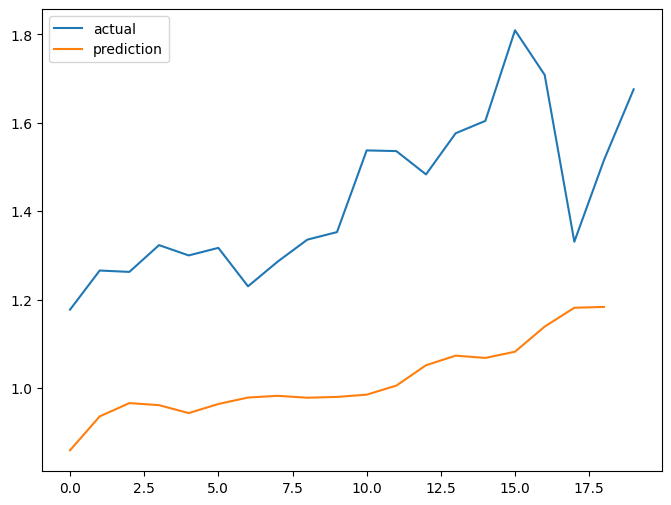

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(np.asarray(test['Close'])[5:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

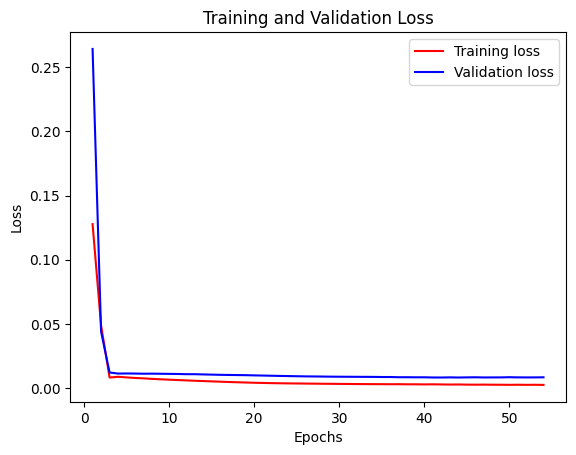

In [26]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [27]:
score = model.evaluate(test_data)
score

19/19 [==============================] - 0s 5ms/step - loss: 0.0897 - mse: 0.1793


[0.08966552466154099, 0.17933104932308197]

# 변수 중요도

In [28]:
pip install --upgrade shap

In [45]:
import skimage
skimage.__version__

'0.19.3'

In [85]:
print(dummy_data.shape)
print(df.iloc[[0]].shape)

(1, 7)
(1, 7)


In [29]:
import shap

# Assuming x_train is a DataFrame
masker = shap.maskers.Independent(df)

# Assuming model is your trained model
explainer = shap.Explainer(model, masker=masker)

# Choose a single instance from your dataset
single_instance = df.iloc[[7]]  # Adjust the index as needed

single_instance_df = pd.DataFrame(single_instance, columns=df.columns)

# Compute SHAP values for the chosen instance
shap_values_single = explainer(single_instance_df)

# Now you can use shap.summary_plot with the computed SHAP values
shap.summary_plot(shap_values_single, single_instance_df)


AttributeError: ignored